## Demo code for Bayesian inference

In this notebook we illustrate some of the basic models and priors for Bayesian inference. These concepts will be important for our discussions about "topic models."

First, we illustrate the situation where the parameter $\theta$ that we are modeling is a Bernoulli parameter.
This can be thought of as the probability that flipping a certain coin comes up heads. The most commonly used prior distribution for this model is a beta distribution. Under a beta prior, the posterior distribution is again a beta distribution. 

This is illustrated in the following simulation. As the number of observed data points increases, this shows how the posterior becomes concentrated on the true parameter. But as the variance of the prior decreases, it takes longer and longer to converge to the true parameter.


In [1]:
import os, gzip
import numpy as np
import matplotlib.pyplot as plt


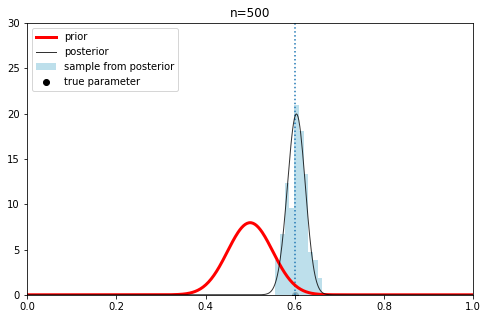

In [2]:
%matplotlib inline
from scipy.special import gamma
from numpy import random
from scipy.stats import beta
from IPython.display import clear_output
from time import sleep

theta = np.linspace(0,1,num=500)

# The following are the parameters of the prior beta distribution. As the scale increases, the 
# variance of the prior decreases. We can see how this results in a larger amount of data required for 
# the posterior to be centered on the true parameter

scale = 50
a0 = scale*1
b0 = scale*1

sample_size = 100
p = 0.6
prior = beta.pdf(theta, a0, b0)

for n in np.arange(0, 501, 5):
    # sample from a coin with probability of heads p
    x = random.multinomial(n, pvals=[p, 1-p])
    
    # calculate the posterior alpha and beta parameters
    a = a0 + x[0]
    b = b0 + x[1]
    posterior = beta.pdf(theta, a, b)
    
    # sample from the posterior
    posterior_sample = np.random.beta(a, b, size=sample_size)
    
    # plot everything
    clear_output(wait=True)
    plt.figure(figsize=(8,5))
    plt.title('n=%d' % n)
    plt.plot(theta, prior, linewidth=3, color='red', label='prior')
    plt.plot(theta, posterior, linewidth=1, color='black', alpha=.8, label='posterior')
    plt.xlim((0, 1))
    plt.ylim((0,30))
    plt.hist(posterior_sample, density=True, color='lightblue', alpha=.8, label='sample from posterior')
    plt.scatter([p], [0], color='black', label='true parameter')
    plt.vlines([p], ymin=0, ymax=30, linestyles='dotted')
    plt.legend(loc='upper left')
    plt.show()
    sleep(.1)



# Going from a coin to a 3-sided die

The next cell defines some helper functions for displaying probabilities for a 3-sided die (whatever that is!) otherwise known as a "2-simplex."  Don't worry about the details -- just take them as a built-in set of functions.


In [3]:
# https://github.com/WillKoehrsen/probabilistic-programming/blob/master/utils.py

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from functools import reduce

_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])
_midpoints = [(_corners[(i + 1) % 3] + _corners[(i + 2) % 3]) / 2.0 \
              for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.
    Arguments:
        `xy`: A length-2 sequence containing the x and y value.
    '''
    s = [(_corners[i] - _midpoints[i]).dot(xy - _midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        '''Creates Dirichlet distribution with parameter `alpha`.'''
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])
    def sample(self, N):
        '''Generates a random sample of size `N`.'''
        return np.random.dirichlet(self._alpha, N)

def draw_pdf_contours(dist, border=False, nlevels=200, subdiv=5, **kwargs):
    '''Draws pdf contours over an equilateral triangle (2-simplex).
    Arguments:
        `dist`: A distribution instance with a `pdf` method.
        `border` (bool): If True, the simplex border is drawn.
        `nlevels` (int): Number of contours to draw.
        `subdiv` (int): Number of recursive mesh subdivisions to create.
        kwargs: Keyword args passed on to `plt.triplot`.
    '''
    from matplotlib import ticker, cm
    import math

    refiner = tri.UniformTriRefiner(_triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    if border is True:
        plt.triplot(_triangle, linewidth=1)

def plot_points(X, barycentric=True, border=True, **kwargs):
    '''Plots a set of points in the simplex.
    Arguments:
        `X` (ndarray): A 2xN array (if in Cartesian coords) or 3xN array
                       (if in barycentric coords) of points to plot.
        `barycentric` (bool): Indicates if `X` is in barycentric coords.
        `border` (bool): If True, the simplex border is drawn.
        kwargs: Keyword args passed on to `plt.plot`.
    '''
    if barycentric is True:
        X = X.dot(_corners)
    plt.plot(X[:, 0], X[:, 1], 'k.', ms=1, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    if border is True:
        plt.triplot(_triangle, linewidth=1)



## Sampling from a Dirichlet distribution

In the following cell, we show four Dirichlet distributions in the top row.
In bottom row, we show $1000$ samples randomly drawn from each distribution. 
Note that as the parameters of the Dirichlet get smaller, the points get pushed out
toward the boundary.

The Dirichlet can be seen as a prior distribution over weighted (3-sided) die.
Each draw from the Dirichlet corresponds to a particular weighted die.


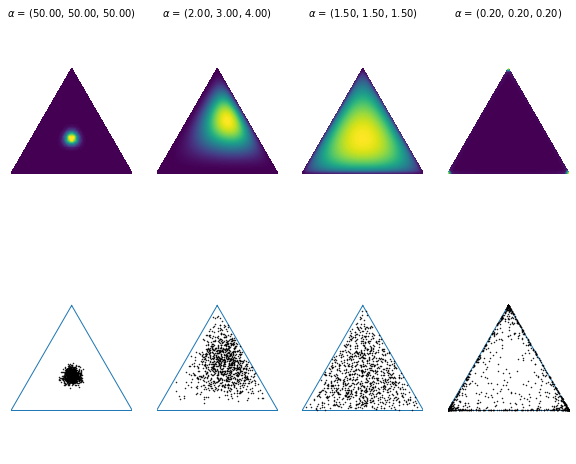

In [4]:
%matplotlib inline

f = plt.figure(figsize=(10, 8))
alphas = [[50] * 3, [2, 3, 4], [1.5] * 3, [.20] * 3]
for (i, alpha) in enumerate(alphas):
    plt.subplot(2, len(alphas), i + 1)
    dist = Dirichlet(alpha)
    draw_pdf_contours(dist)
    title = r'$\alpha$ = (%.2f, %.2f, %.2f)' % tuple(alpha)
    plt.title(title, fontdict={'fontsize': 10})
    plt.subplot(2, len(alphas), i + 1 + len(alphas))
    plot_points(dist.sample(1000))

plt.show()

## Your turn!

Use these plotting functions to illustrate Bayesian inference by sampling data from a particular multinomial, 
and plotting the posterior distribution under a given Dirichlet prior.  Specifically, plot the prior, plot the data, and then plot the posterior distribution, using the functions we provide above. 

(You might even try to generate a movie for different sample sizes, as we did above for a single Bernoulli random variable, corresponding to a 2-sided die or coin).

Give it a try. If you are able to understand what's going on it will help a lot when we talk about topic models next week.

